In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
#sys.path.append('C:\\Users\\Graúna Motos\\Documents\\credit_risk')
sys.path.append('/home/noise/Documentos/credit_risk')
from src.utils_modelling import analisy_univariate, wo_discretize, plot_woe, wo_discretize_continuos, 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from src.utils_modelling import LogisticRegressionPvalues
import mlflow
import warnings

warnings.filterwarnings('ignore')

In [2]:

#LINUX
input_train = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_inputs_train.csv', index_col=0)
target_train = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_targets_train.csv', index_col=0, header= None)
input_test = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_inputs_test.csv', index_col=0)
target_test = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_targets_test.csv', index_col=0, header= None)
df = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_2007_2014.csv')

In [3]:
'''input_train = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_inputs_train.csv', index_col=0)
target_train = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_targets_train.csv', index_col=0, header=None  )
input_test = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_inputs_test.csv', index_col=0)
target_test = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_targets_test.csv', index_col=0, header=None)'''

"input_train = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_inputs_train.csv', index_col=0)\ntarget_train = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_targets_train.csv', index_col=0, header=None  )\ninput_test = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_inputs_test.csv', index_col=0)\ntarget_test = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\silver\\loan_data_targets_test.csv', index_col=0, header=None)"

In [4]:
target_train.head()

,1
0,
NaN,good_bad
427211.0,1
206088.0,1
136020.0,1
412305.0,0


In [5]:
# Remove the 'good_bad' row and convert to numeric
target_train = target_train.apply(pd.to_numeric, errors='coerce')

# Remove any remaining non-numeric values
target_train = target_train.dropna()

# Reset the index
target_train = target_train.reset_index(drop=True)



In [6]:
target_train.shape


(373028, 1)

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

def analise_qui_quadrado(df, var_categorica, var_alvo, plot=True):
    """
    Realiza teste qui-quadrado e análise de associação entre variáveis categóricas
    
    Parâmetros:
    df : DataFrame
        DataFrame contendo os dados
    var_categorica : str
        Nome da variável categórica independente
    var_alvo : str
        Nome da variável categórica alvo
    plot : bool
        Se True, gera visualização da tabela de contingência
        
    Retorna:
    dict com resultados da análise
    """
    # Criar tabela de contingência
    cont_table = pd.crosstab(df[var_categorica], df[var_alvo])
    
    # Realizar teste qui-quadrado
    chi2, p_valor, gl, esperado = chi2_contingency(cont_table)
    
    # Calcular V de Cramer (medida de associação)
    n = cont_table.sum().sum()
    min_dim = min(cont_table.shape) - 1
    v_cramer = np.sqrt(chi2 / (n * min_dim))
    
    # Calcular frequências relativas
    freq_relativa = pd.crosstab(df[var_categorica], df[var_alvo], normalize='index') * 100
    
    if plot:
        plt.figure(figsize=(10, 6))
        sns.heatmap(freq_relativa, annot=True, fmt='.1f', cmap='YlOrRd')
        plt.title(f'Distribuição de {var_alvo} por {var_categorica} (%)')
        plt.ylabel(var_categorica)
        plt.xlabel(var_alvo)
    
    resultados = {
        'estatistica_chi2': chi2,
        'p_valor': p_valor,
        'graus_liberdade': gl,
        'v_cramer': v_cramer,
        'tabela_contingencia': cont_table,
        'frequencias_relativas': freq_relativa
    }
    
    return resultados

# Exemplo de uso
# dados = pd.DataFrame({
#     'escolaridade': ['Superior', 'Médio', 'Superior', 'Fundamental', 'Médio'],
#     'inadimplente': ['Sim', 'Não', 'Não', 'Sim', 'Não']
# })
#
# resultados = analise_qui_quadrado(dados, 'escolaridade', 'inadimplente')
#
# # Interpretação dos resultados
# print(f"Estatística Chi2: {resultados['estatistica_chi2']:.2f}")
# print(f"P-valor: {resultados['p_valor']:.4f}")
# print(f"V de Cramer: {resultados['v_cramer']:.4f}")

In [8]:
target_train.shape


(373028, 1)

# Train model PD

In [9]:
inputs_train_with_ref_cat = input_train.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ_smb_wedd_ren_en_mov_house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth_med_vacation',
'purpose:major_car_home',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
'open_acc:1-3',
'open_acc:4-12',
'open_acc:13-17',
'open_acc:18-22',
'open_acc:23-25',
'open_acc:26-30',
'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
]]    

In [10]:
ref_categories = [
    'grade:G',
    'home_ownership:RENT_OTHER_NONE_ANY',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'verification_status:Verified',
    'purpose:educ_smb_wedd_ren_en_mov_house',  
    'initial_list_status:f',
    'term:60',
    'emp_length:0',
    'mths_since_issue_d:>84',
    'int_rate:>20.281',
    'mths_since_earliest_cr_line:<140',
    'delinq_2yrs:>=4',
    'inq_last_6mths:>6',
    'open_acc:0',
    'pub_rec:0-2',
    'total_acc:<=27',
    'acc_now_delinq:0',
    'total_rev_hi_lim:<=5K',
    'annual_inc:<20K',
    'dti:>35',
    'mths_since_last_delinq:0-3',
    'mths_since_last_record:0-2'
]

In [11]:
input_train = inputs_train_with_ref_cat.drop(ref_categories, axis=1)
input_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,True,False,False,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
206088,False,False,True,False,False,False,False,True,0,False,...,0,1,0,0,1,0,0,0,0,0
136020,True,False,False,False,False,False,False,True,0,False,...,0,0,1,0,1,0,0,0,0,0
412305,False,False,False,True,False,False,False,False,0,False,...,0,1,0,0,1,0,0,0,0,0
36159,False,False,True,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0


# Logistic Regression Model

In [12]:
reg = LogisticRegression()

In [13]:
input_train.shape
#target_train.shape

(373028, 104)

In [14]:
print(target_train)

          1
0       1.0
1       1.0
2       1.0
3       0.0
4       0.0
...     ...
373023  1.0
373024  1.0
373025  1.0
373026  1.0
373027  1.0

[373028 rows x 1 columns]


In [15]:
target_train.shape

(373028, 1)

In [16]:
target_train.head()

,1
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0


In [17]:
input_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,True,False,False,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
206088,False,False,True,False,False,False,False,True,0,False,...,0,1,0,0,1,0,0,0,0,0
136020,True,False,False,False,False,False,False,True,0,False,...,0,0,1,0,1,0,0,0,0,0
412305,False,False,False,True,False,False,False,False,0,False,...,0,1,0,0,1,0,0,0,0,0
36159,False,False,True,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0


In [18]:
import numpy as np
from scipy import stats

In [19]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import pandas as pd

class LogisticRegressionP:
    def __init__(self, alpha=0.0001, method='l1'):
        self.alpha = alpha
        self.method = method
        self.model = None
        self.removed_cols = []
        
    def _check_data(self, X):
        """
        Verifica e processa os dados de entrada
        """
        X = X.copy()
        
        # Converte todas as colunas para numéricas, tratando erros
        for col in X.columns:
            try:
                X[col] = pd.to_numeric(X[col], errors='raise')
            except:
                print(f"Warning: Column {col} could not be converted to numeric. Removing it.")
                X = X.drop(columns=[col])
                self.removed_cols.append(col)
        
        # Verifica variância zero
        constant_cols = []
        for col in X.columns:
            if X[col].std() < 1e-6:
                constant_cols.append(col)
                
        if constant_cols:
            print(f"Warning: Columns with near-zero variance: {constant_cols}")
            X = X.drop(columns=constant_cols)
            self.removed_cols.extend(constant_cols)
            
        # Verifica multicolinearidade
        if X.shape[1] > 1:
            corr_matrix = X.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            high_corr = [(i, j) for i, j in zip(*np.where(upper > 0.95))]
            
            if high_corr:
                print(f"Warning: High correlation (>0.95) between features: {high_corr}")
                # Opcional: remover uma das colunas altamente correlacionadas
                cols_to_remove = [pair[1] for pair in high_corr]
                if cols_to_remove:
                    X = X.drop(columns=X.columns[cols_to_remove])
                    self.removed_cols.extend(X.columns[cols_to_remove])
                    print(f"Removed highly correlated columns: {X.columns[cols_to_remove]}")
        
        # Verifica se há valores nulos
        if X.isnull().any().any():
            print("Warning: Data contains null values. Filling with 0...")
            X = X.fillna(0)
            
        return X
    
    def fit(self, X, y):
        try:
            # Converte para DataFrame se não for
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X)
            
            # Converte y para numpy array se não for
            if isinstance(y, pd.Series):
                y = y.values
            elif isinstance(y, pd.DataFrame):
                y = y.values.ravel()
            elif not isinstance(y, np.ndarray):
                y = np.array(y)
            
            # Converte y para float64
            y = y.astype(np.float64)
                
            # Garante que y seja um array 2D
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
                
            # Checa e limpa os dados
            X = self._check_data(X)
            
            # Verifica se ainda há colunas após o processamento
            if X.shape[1] == 0:
                raise ValueError("No columns remained after data processing!")
            
            # Converte para array numpy
            X_array = X.astype(np.float64)
            
            # Adiciona constante
            X_copy = sm.add_constant(X_array)
            
            # Tenta fit com diferentes valores de alpha se necessário
            try:
                self.model = sm.Logit(y, X_copy).fit_regularized(
                    alpha=self.alpha, 
                    method=self.method,
                    maxiter=1000,
                    cnvrg_tol=1e-8
                )
            except np.linalg.LinAlgError:
                print("Warning: Singular matrix detected. Trying with higher regularization...")
                self.alpha = max(0.01, self.alpha * 10)
                self.model = sm.Logit(y, X_copy).fit_regularized(
                    alpha=self.alpha,
                    method=self.method
                )
                
        except Exception as e:
            print(f"Error during fitting: {str(e)}")
            print("\nShape of X:", X.shape)
            print("Shape of y:", y.shape)
            print("X dtypes:\n", X.dtypes)
            print("y dtype:", y.dtype)
            raise e

    def predict(self, X):
        try:
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X)
            
            # Remove as colunas que foram removidas durante o fit
            if self.removed_cols:
                X = X.drop(columns=list(set(self.removed_cols) & set(X.columns)))
                
            X = self._check_data(X)
            X_array = X.astype(np.float64)
            X_copy = sm.add_constant(X_array)
            
            return self.model.predict(X_copy)
            
        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            raise e
    
    def get_summary_table(self):
        try:
            summary = self.model.summary2().tables[1]
            summary['Wald'] = summary['z'] ** 2
            summary_table = summary[['Coef.', 'P>|z|', 'Wald']]
            summary_table.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
            summary_table = summary_table.sort_index()
            summary_table['P-Value'] = summary_table['P-Value'].apply(lambda x: '{:.20f}'.format(x))   
            return summary_table
            
        except Exception as e:
            print(f"Error getting summary table: {str(e)}")
            raise e

In [20]:
feature_name = input_train.columns.values
# Stores the names of the columns of a dataframe in a variable.

In [21]:
target_train.head()

,1
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0


In [22]:
target_train

,1
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
373023,1.0
373024,1.0
373025,1.0
373026,1.0


In [23]:
reg2 = LogisticRegressionP(alpha=1, method='l1')
reg2.fit(input_train, target_train)


Removed highly correlated columns: Index(['inq_last_6mths:0'], dtype='object')
Iteration limit reached    (Exit mode 9)
            Current function value: 0.3230432107853324
            Iterations: 1000
            Function evaluations: 1000
            Gradient evaluations: 1000


/home/noise/anaconda3/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 48 out of 93 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/noise/anaconda3/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/noise/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
summary_table = reg2.get_summary_table()

In [25]:
summary_table.head(200)

,Beta Coefficient,P-Value,Wald Statistic
acc_now_delinq:>=1,0.223302,0.03472444999310544261,4.458674
addr_state:AR_MI_PA_OH_MN,0.136753,0.00000000126964014721,36.859376
addr_state:CA,0.048391,0.02239828191430934257,5.214578
addr_state:GA_WA_OR,0.174316,0.00000000006089310183,42.791599
addr_state:IL_CT,0.260050,0.00000000000000000051,79.387123
...,...,...,...
total_rev_hi_lim:55K-95K,0.530958,0.00000000000000000000,342.692300
total_rev_hi_lim:5K-10K,0.434325,0.00000000000000000000,415.908517
total_rev_hi_lim:>95K,0.704993,0.00000000000000000000,185.014779
verification_status:Not Verified,0.135734,0.00000000000000000000,88.961299


In [26]:
# Define columns to drop
columns_to_drop = [
    'open_acc:1-3', 'open_acc:13-17', 'open_acc:18-22', 'open_acc:23-25',
    'open_acc:26-30', 'open_acc:4-12', 'open_acc:>=31', 'pub_rec:3-4', 'pub_rec:>=5',
    'term:36', 'total_acc:28-51', 'total_acc:>=52',
    'emp_length:1', 'emp_length:10', 'emp_length:2-4', 'emp_length:5-6', 'emp_length:7-9',
    'mths_since_earliest_cr_line:>352'
]

# Drop the columns from input_train
input_train = input_train.drop(columns=columns_to_drop)



In [27]:
'''mlflow.set_tracking_uri(uri='http://localhost:5001')
mlflow.set_experiment(experiment_id=1)
mlflow.autolog()'''

"mlflow.set_tracking_uri(uri='http://localhost:5001')\nmlflow.set_experiment(experiment_id=1)\nmlflow.autolog()"

In [28]:


reg3 = LogisticRegression()
reg3.fit(input_train, target_train)

LogisticRegression()

In [29]:
'''import os
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression

# Configuração do URI de tracking do MLflow e das variáveis de ambiente para o MinIO
mlflow.set_tracking_uri("http://localhost:5001")  # URI do MLflow ajustado para a porta 5001
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9005"  # Porta do MinIO ajustada para 9005
os.environ["AWS_ACCESS_KEY_ID"] = "mlflow"
os.environ["AWS_SECRET_ACCESS_KEY"] = "password"

# Dados de entrada para o treinamento do modelo (defina input_train e target_train antes do uso)
# Exemplo de definição (substitua com os dados reais):
# input_train, target_train = <seu_código_para_carregar_dados>()

# Treinamento do modelo e logging no MLflow
try:
    with mlflow.start_run():
        # Treinamento do modelo
        reg3 = LogisticRegression()
        reg3.fit(input_train, target_train)  # Defina input_train e target_train antes do uso

        # Log de parâmetros do modelo
        mlflow.log_param("model_type", "LogisticRegression")
        
        # Log de métricas
        train_score = reg3.score(input_train, target_train)
        mlflow.log_metric("train_accuracy", train_score)
        
        # Log do modelo no MLflow
        mlflow.sklearn.log_model(reg3, "model")
        
        print("Execução e log concluídos com sucesso.")
except Exception as e:
    print(f"Ocorreu um erro ao iniciar a execução do MLflow: {e}")
'''

'import os\nimport mlflow\nimport mlflow.sklearn\nfrom sklearn.linear_model import LogisticRegression\n\n# Configuração do URI de tracking do MLflow e das variáveis de ambiente para o MinIO\nmlflow.set_tracking_uri("http://localhost:5001")  # URI do MLflow ajustado para a porta 5001\nos.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9005"  # Porta do MinIO ajustada para 9005\nos.environ["AWS_ACCESS_KEY_ID"] = "mlflow"\nos.environ["AWS_SECRET_ACCESS_KEY"] = "password"\n\n# Dados de entrada para o treinamento do modelo (defina input_train e target_train antes do uso)\n# Exemplo de definição (substitua com os dados reais):\n# input_train, target_train = <seu_código_para_carregar_dados>()\n\n# Treinamento do modelo e logging no MLflow\ntry:\n    with mlflow.start_run():\n        # Treinamento do modelo\n        reg3 = LogisticRegression()\n        reg3.fit(input_train, target_train)  # Defina input_train e target_train antes do uso\n\n        # Log de parâmetros do modelo\n        m

In [30]:
reg3

LogisticRegression()

In [31]:
# First, let's check which columns are available in input_test to avoid KeyError
available_columns = input_test.columns.tolist()

# Define the columns we want to select
desired_columns = [
    'grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ_smb_wedd_ren_en_mov_house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth_med_vacation',
'purpose:major_car_home',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
'open_acc:1-3',
'open_acc:4-12',
'open_acc:13-17',
'open_acc:18-22',
'open_acc:23-25',
'open_acc:26-30',
'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
]

# Filter the desired columns to only include those that are available in input_test
filtered_columns = [col for col in desired_columns if col in available_columns]

# Select the filtered columns from input_test
inputs_test_with_ref_cat = input_test.loc[:, filtered_columns]

In [32]:
ref_categories = ['grade:G',
    'home_ownership:RENT_OTHER_NONE_ANY',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'verification_status:Verified',
    'purpose:educ_smb_wedd_ren_en_mov_house',  
    'initial_list_status:f',
    'term:60',
    'emp_length:0',
    'mths_since_issue_d:>84',
    'int_rate:>20.281',
    'mths_since_earliest_cr_line:<140',
    'delinq_2yrs:>=4',
    'inq_last_6mths:>6',
    'open_acc:0',
    'pub_rec:0-2',
    'total_acc:<=27',
    'acc_now_delinq:0',
    'total_rev_hi_lim:<=5K',
    'annual_inc:<20K',
    'dti:>35',
    'mths_since_last_delinq:0-3',
    'mths_since_last_record:0-2']

In [33]:
input_test_2 = inputs_test_with_ref_cat.drop(ref_categories, axis=1)
input_test_2

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,False,False,True,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
288564,False,False,False,False,True,False,False,True,0,False,...,0,0,0,0,1,0,0,0,0,0
213591,False,False,True,False,False,False,False,True,0,False,...,0,0,1,0,1,0,0,0,0,0
263083,False,False,True,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
165001,True,False,False,False,False,False,False,True,0,False,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,False,True,False,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
296284,False,True,False,False,False,False,False,False,0,False,...,0,0,0,1,1,0,0,0,0,0
61777,True,False,False,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0
91763,True,False,False,False,False,False,False,True,0,False,...,1,0,0,0,1,0,0,0,0,0


In [34]:
columns_to_drop = [
    'open_acc:1-3', 'open_acc:13-17', 'open_acc:18-22', 'open_acc:23-25',
    'open_acc:26-30', 'open_acc:4-12', 'open_acc:>=31', 'pub_rec:3-4', 'pub_rec:>=5',
    'term:36', 'total_acc:28-51', 'total_acc:>=52',
    'emp_length:1', 'emp_length:10', 'emp_length:2-4', 'emp_length:5-6', 'emp_length:7-9',
    'mths_since_earliest_cr_line:>352'
]

# Drop the columns from input_train
input_test_2 = input_test_2.drop(columns=columns_to_drop)

In [35]:
y_hat_test = reg3.predict(input_test_2)

In [36]:
y_hat_test

array([1., 1., 1., ..., 1., 1., 1.])

In [37]:
y_hat_test_proba = reg3.predict_proba(input_test_2)
y_hat_test_proba

array([[0.09130686, 0.90869314],
       [0.19271701, 0.80728299],
       [0.10486505, 0.89513495],
       ...,
       [0.02461013, 0.97538987],
       [0.04379023, 0.95620977],
       [0.03840379, 0.96159621]])

In [38]:
y_hat_test_proba = y_hat_test_proba[: ][: , 1]


In [39]:
# Remove the 'good_bad' row and convert to numeric
target_test = target_test.apply(pd.to_numeric, errors='coerce')

# Remove any remaining non-numeric values
target_test = target_test.dropna()

# Reset the index
target_test = target_test.reset_index(drop=True)


In [40]:
target_test = pd.DataFrame(target_test)

In [41]:
target_test_temp = target_test

In [42]:
target_test_temp.reset_index(drop=True, inplace=True)

In [43]:
print(target_test_temp)

         1
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
...    ...
93252  1.0
93253  1.0
93254  0.0
93255  1.0
93256  1.0

[93257 rows x 1 columns]


In [44]:
df_actual_predict_proba = pd.concat([target_test_temp, pd.DataFrame(y_hat_test_proba)], axis=1)

In [45]:
df_actual_predict_proba.shape

(93257, 2)

In [46]:
df_actual_predict_proba.columns = ['target_test', 'y_hat_test_proba']


In [47]:
df_actual_predict_proba.head()

,target_test,y_hat_test_proba
0,1.0,0.908693
1,1.0,0.807283
2,1.0,0.895135
3,1.0,0.917017
4,1.0,0.973325


In [48]:
tr = 0.5
df_actual_predict_proba['y_hat_test'] = np.where(df_actual_predict_proba['y_hat_test_proba'] > tr, 1, 0)

In [49]:
pd.crosstab(df_actual_predict_proba['target_test'], df_actual_predict_proba['y_hat_test'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0.0,5,10185
1.0,7,83060


In [50]:
pd.crosstab(df_actual_predict_proba['target_test'], df_actual_predict_proba['y_hat_test'], rownames=['Actual'], colnames=['Predicted']) / df_actual_predict_proba.shape[0]

Predicted,0,1
Actual,,
0.0,0.000054,0.109214
1.0,0.000075,0.890657


In [51]:
from sklearn.metrics import roc_curve, roc_auc_score


In [52]:
roc_curve(df_actual_predict_proba['target_test'], df_actual_predict_proba['y_hat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99980373, 1.        ,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 8.18616298e-04, ...,
        9.99987962e-01, 9.99987962e-01, 1.00000000e+00]),
 array([       inf, 0.98987167, 0.98606555, ..., 0.38988811, 0.38615875,
        0.36209658]))

In [53]:
fpr, tpr, thereshholds = roc_curve(df_actual_predict_proba['target_test'], df_actual_predict_proba['y_hat_test_proba'])

Text(0.5, 1.0, 'ROC curve')

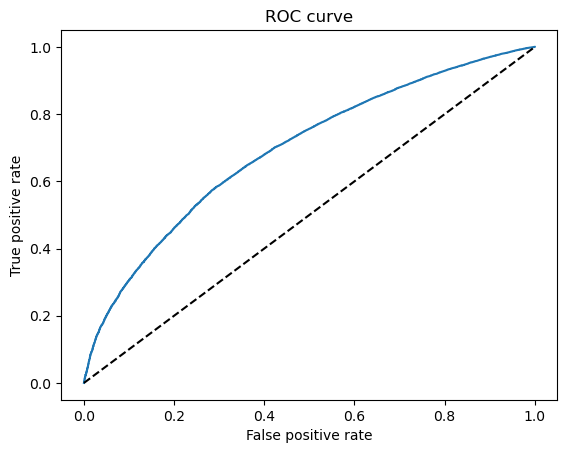

In [54]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [55]:
AUC = roc_auc_score(df_actual_predict_proba['target_test'], df_actual_predict_proba['y_hat_test_proba'])
AUC

0.6938124636918592

## GINI AND KOLMOGOROV-SMIRNOV

In [56]:
df_actual_predict_proba = df_actual_predict_proba.sort_values('y_hat_test_proba')

In [57]:
df_actual_predict_proba.tail(10)

,target_test,y_hat_test_proba,y_hat_test
79625,1.0,0.988295,1
59452,1.0,0.988342,1
36958,1.0,0.988587,1
28298,1.0,0.988712,1
80020,1.0,0.988795,1
16899,1.0,0.989401,1
49559,1.0,0.989507,1
26378,1.0,0.989541,1
92691,1.0,0.989581,1
54837,1.0,0.989872,1


In [58]:
df_actual_predict_proba = df_actual_predict_proba.reset_index()

In [59]:
df_actual_predict_proba.head()

,index,target_test,y_hat_test_proba,y_hat_test
0,14868,1.0,0.362097,0
1,48752,0.0,0.386159,0
2,67123,0.0,0.389280,0
3,58288,1.0,0.389888,0
4,3525,0.0,0.436406,0


In [60]:
df_actual_predict_proba['Cumulative N Populations'] = df_actual_predict_proba.index + 1

df_actual_predict_proba['Cumulative N Good'] = df_actual_predict_proba['target_test'].cumsum()

df_actual_predict_proba['Cumulative N Bad'] = df_actual_predict_proba['Cumulative N Populations'] - df_actual_predict_proba['target_test'].cumsum()

In [61]:
df_actual_predict_proba.head()

,index,target_test,y_hat_test_proba,y_hat_test,Cumulative N Populations,Cumulative N Good,Cumulative N Bad
0,14868,1.0,0.362097,0,1,1.0,0.0
1,48752,0.0,0.386159,0,2,1.0,1.0
2,67123,0.0,0.389280,0,3,1.0,2.0
3,58288,1.0,0.389888,0,4,2.0,2.0
4,3525,0.0,0.436406,0,5,2.0,3.0


In [62]:
df_actual_predict_proba['Cumulative Perc Populations'] = df_actual_predict_proba['Cumulative N Populations'] /(df_actual_predict_proba.shape[0])

df_actual_predict_proba['Cumulative Perc Good'] = df_actual_predict_proba['Cumulative N Good'] / df_actual_predict_proba['target_test'].sum()

df_actual_predict_proba['Cumulative Perc Bad'] = df_actual_predict_proba['Cumulative N Bad'] /(df_actual_predict_proba.shape[0] - df_actual_predict_proba['target_test'].sum())

Text(0.5, 1.0, 'Gini')

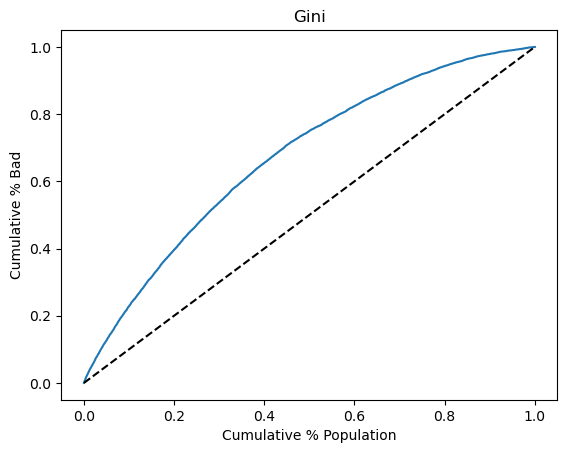

In [63]:
plt.plot(df_actual_predict_proba['Cumulative Perc Populations'], df_actual_predict_proba['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_actual_predict_proba['Cumulative Perc Populations'], df_actual_predict_proba['Cumulative Perc Populations'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')

In [64]:
gini = AUC * 2 -1
gini

0.38762492738371845

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

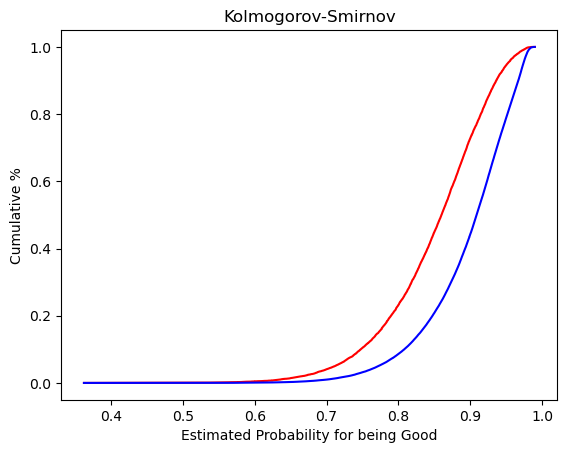

In [65]:
# Plot KS
plt.plot(df_actual_predict_proba['y_hat_test_proba'], df_actual_predict_proba['Cumulative Perc Bad'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(df_actual_predict_proba['y_hat_test_proba'], df_actual_predict_proba['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [66]:
df_actual_predict_proba.head()

,index,target_test,y_hat_test_proba,y_hat_test,Cumulative N Populations,Cumulative N Good,Cumulative N Bad,Cumulative Perc Populations,Cumulative Perc Good,Cumulative Perc Bad
0,14868,1.0,0.362097,0,1,1.0,0.0,0.000011,0.000012,0.000000
1,48752,0.0,0.386159,0,2,1.0,1.0,0.000021,0.000012,0.000098
2,67123,0.0,0.389280,0,3,1.0,2.0,0.000032,0.000012,0.000196
3,58288,1.0,0.389888,0,4,2.0,2.0,0.000043,0.000024,0.000196
4,3525,0.0,0.436406,0,5,2.0,3.0,0.000054,0.000024,0.000294


In [67]:
ks_value = max(df_actual_predict_proba['Cumulative Perc Bad'] - df_actual_predict_proba['Cumulative Perc Good'])


In [68]:
ks_value

0.2898486416364916

In [69]:

pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.width = None


# Score Card

In [83]:
ref_categories

['grade:G',
 'home_ownership:RENT_OTHER_NONE_ANY',
 'addr_state:ND_NE_IA_NV_FL_HI_AL',
 'verification_status:Verified',
 'purpose:educ_smb_wedd_ren_en_mov_house',
 'initial_list_status:f',
 'term:60',
 'emp_length:0',
 'mths_since_issue_d:>84',
 'int_rate:>20.281',
 'mths_since_earliest_cr_line:<140',
 'delinq_2yrs:>=4',
 'inq_last_6mths:>6',
 'open_acc:0',
 'pub_rec:0-2',
 'total_acc:<=27',
 'acc_now_delinq:0',
 'total_rev_hi_lim:<=5K',
 'annual_inc:<20K',
 'dti:>35',
 'mths_since_last_delinq:0-3',
 'mths_since_last_record:0-2']

In [70]:
summary_table

,Beta Coefficient,P-Value,Wald Statistic
acc_now_delinq:>=1,0.223302,0.03472444999310544261,4.458674e+00
addr_state:AR_MI_PA_OH_MN,0.136753,0.00000000126964014721,3.685938e+01
addr_state:CA,0.048391,0.02239828191430934257,5.214578e+00
addr_state:GA_WA_OR,0.174316,0.00000000006089310183,4.279160e+01
addr_state:IL_CT,0.260050,0.00000000000000000051,7.938712e+01
addr_state:KS_SC_CO_VT_AK_MS,0.324689,0.00000000000000000000,1.111320e+02
addr_state:NM_VA,0.025537,0.42437479595182181491,6.381685e-01
addr_state:NY,0.049201,0.04224845237333795661,4.125223e+00
addr_state:OK_TN_MO_LA_MD_NC,0.061126,0.00828340327161380952,6.971155e+00
addr_state:RI_MA_DE_SD_IN,0.096869,0.00115081760129272302,1.056768e+01


In [84]:
# Definindo a lista de categorias
ref_categories = [
    'grade:G', 
    'home_ownership:RENT_OTHER_NONE_ANY',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'verification_status:Verified',
    'purpose:educ_smb_wedd_ren_en_mov_house',
    'initial_list_status:f',
    'term:60',
    'emp_length:0',
    'mths_since_issue_d:>84',
    'int_rate:>20.281',
    'mths_since_earliest_cr_line:<140',
    'delinq_2yrs:>=4',
    'inq_last_6mths:>6',
    'open_acc:0',
    'pub_rec:0-2',
    'total_acc:<=27',
    'acc_now_delinq:0',
    'total_rev_hi_lim:<=5K',
    'annual_inc:<20K',
    'dti:>35',
    'mths_since_last_delinq:0-3',
    'mths_since_last_record:0-2'
]


In [86]:
referece_categories_scorecard = {key: key+'_'+value for key, value in ref_categories}
scorecard_reference_categories = pd.DataFrame()
scorecard_reference_categories['Dummy'] = list(referece_categories_scorecard.values())
scorecard_reference_categories['Beta Coefficient'] = 0
scorecard_reference_categories['P-Value'] = 'reference category'
scorecard_reference_categories['Wald Statistic'] = 'reference category'
scorecard_reference_categories = scorecard_reference_categories.reset_index(drop=True)
scorecard_reference_categories.index += 87

ValueError: too many values to unpack (expected 2)

In [71]:
df_ref_categories = pd.DataFrame(ref_categories, columns=['Feature name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories['p_values'] = np.nan
df_ref_categories

,Feature name,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA_NV_FL_HI_AL,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ_smb_wedd_ren_en_mov_house,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [72]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
df_scorecard = df_scorecard.reset_index()
df_scorecard

,index,Beta Coefficient,P-Value,Wald Statistic,Feature name,Coefficients,p_values
0,acc_now_delinq:>=1,0.223302,0.03472444999310544261,4.458674e+00,NaN,NaN,NaN
1,addr_state:AR_MI_PA_OH_MN,0.136753,0.00000000126964014721,3.685938e+01,NaN,NaN,NaN
2,addr_state:CA,0.048391,0.02239828191430934257,5.214578e+00,NaN,NaN,NaN
3,addr_state:GA_WA_OR,0.174316,0.00000000006089310183,4.279160e+01,NaN,NaN,NaN
4,addr_state:IL_CT,0.260050,0.00000000000000000051,7.938712e+01,NaN,NaN,NaN
5,addr_state:KS_SC_CO_VT_AK_MS,0.324689,0.00000000000000000000,1.111320e+02,NaN,NaN,NaN
6,addr_state:NM_VA,0.025537,0.42437479595182181491,6.381685e-01,NaN,NaN,NaN
7,addr_state:NY,0.049201,0.04224845237333795661,4.125223e+00,NaN,NaN,NaN
8,addr_state:OK_TN_MO_LA_MD_NC,0.061126,0.00828340327161380952,6.971155e+00,NaN,NaN,NaN
9,addr_state:RI_MA_DE_SD_IN,0.096869,0.00115081760129272302,1.056768e+01,NaN,NaN,NaN


In [75]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Beta Coefficient,P-Value,Wald Statistic,Feature name,Coefficients,p_values,Original feature name
0,acc_now_delinq:>=1,0.223302,0.03472444999310544261,4.458674e+00,NaN,NaN,NaN,NaN
1,addr_state:AR_MI_PA_OH_MN,0.136753,0.00000000126964014721,3.685938e+01,NaN,NaN,NaN,NaN
2,addr_state:CA,0.048391,0.02239828191430934257,5.214578e+00,NaN,NaN,NaN,NaN
3,addr_state:GA_WA_OR,0.174316,0.00000000006089310183,4.279160e+01,NaN,NaN,NaN,NaN
4,addr_state:IL_CT,0.260050,0.00000000000000000051,7.938712e+01,NaN,NaN,NaN,NaN
5,addr_state:KS_SC_CO_VT_AK_MS,0.324689,0.00000000000000000000,1.111320e+02,NaN,NaN,NaN,NaN
6,addr_state:NM_VA,0.025537,0.42437479595182181491,6.381685e-01,NaN,NaN,NaN,NaN
7,addr_state:NY,0.049201,0.04224845237333795661,4.125223e+00,NaN,NaN,NaN,NaN
8,addr_state:OK_TN_MO_LA_MD_NC,0.061126,0.00828340327161380952,6.971155e+00,NaN,NaN,NaN,NaN
9,addr_state:RI_MA_DE_SD_IN,0.096869,0.00115081760129272302,1.056768e+01,NaN,NaN,NaN,NaN


In [77]:
df_scorecard.groupby('Original feature name')['Coefficients'].min()

Original feature name
acc_now_delinq                 0.0
addr_state                     0.0
annual_inc                     0.0
delinq_2yrs                    0.0
dti                            0.0
emp_length                     0.0
grade                          0.0
home_ownership                 0.0
initial_list_status            0.0
inq_last_6mths                 0.0
int_rate                       0.0
mths_since_earliest_cr_line    0.0
mths_since_issue_d             0.0
mths_since_last_delinq         0.0
mths_since_last_record         0.0
open_acc                       0.0
pub_rec                        0.0
purpose                        0.0
term                           0.0
total_acc                      0.0
total_rev_hi_lim               0.0
verification_status            0.0
Name: Coefficients, dtype: float64